In [1]:
!python -m spacy download en_core_web_md

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-03-23 22:42:02.058213: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-23 22:42:02.986624: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-23 22:42:02.986706: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open share

In [2]:
import pandas as panda
import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
import string
import nltk
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
import seaborn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer as VS
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import spacy
import re
import en_core_web_md
nlp = en_core_web_md.load() 

import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm


%matplotlib inline
import warnings
warnings.filterwarnings(action = 'ignore')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Read Data

In [4]:
dataset = panda.read_csv("/content/HateSpeechData.csv")
dataset

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


View instances per class

In [5]:
dataset.value_counts(subset='class')

class
1    19190
2     4163
0     1430
dtype: int64

Text(0, 0.5, 'Number of Occurances')

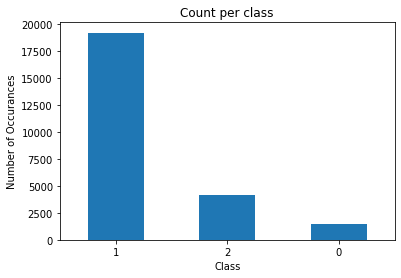

In [6]:
count_classes = dataset.value_counts(dataset['class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Count per class")
plt.xlabel("Class")
plt.ylabel("Number of Occurances")

In [7]:
# collecting only the tweets from the csv file into a variable name tweet
tweet=dataset.tweet

In [8]:
print(tweet.head())

0    !!! RT @mayasolovely: As a woman you shouldn't...
1    !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2    !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3    !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4    !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
Name: tweet, dtype: object


Pre processing tweets

In [10]:
# drop duplicate tweet
tweet.drop_duplicates(inplace = True)


In [9]:
## 1. Removal of punctuation and capitlization
## 2. Tokenizing
## 3. Removal of stopwords
## 4. Stemming

stopwords = nltk.corpus.stopwords.words("english")

In [11]:
#extending the stopwords to include other words used in twitter such as retweet(rt) etc.
other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)
stemmer = PorterStemmer()

In [12]:

def preprocess(tweet):  
    
    # removal of extra spaces
    regex_pat = re.compile(r'\s+')
    tweet_space = tweet.str.replace(regex_pat, ' ')

    # removal of @name[mention]
    regex_pat = re.compile(r'@[\w\-]+')
    tweet_name = tweet_space.str.replace(regex_pat, '')

    # removal of links[https://abc.com]
    giant_url_regex =  re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    tweets = tweet_name.str.replace(giant_url_regex, '')
    
    # removal of punctuations and numbers
    punc_remove = tweets.str.replace("[^a-zA-Z]", " ")
    # remove whitespace with a single space
    newtweet=punc_remove.str.replace(r'\s+', ' ')
    # remove leading and trailing whitespace
    newtweet=newtweet.str.replace(r'^\s+|\s+?$','')
    # replace normal numbers with numbr
    newtweet=newtweet.str.replace(r'\d+(\.\d+)?','numbr')
    # removal of capitalization
    tweet_lower = newtweet.str.lower()
    
    # tokenizing
    tokenized_tweet = tweet_lower.apply(lambda x: x.split())
    
    # removal of stopwords
    tokenized_tweet=  tokenized_tweet.apply(lambda x: [item for item in x if item not in stopwords])
    
    # stemming of the tweets
    tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) 
    
    for i in range(len(tokenized_tweet)):
        tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
        tweets_p= tokenized_tweet
    
    return tweets_p

processed_tweets = preprocess(tweet)   

dataset['processed_tweets'] = processed_tweets
print(dataset[["processed_tweets"]].head(10))

                                    processed_tweets
0  woman complain clean hous amp man alway take t...
1  boy dat cold tyga dwn bad cuffin dat hoe st place
2         dawg ever fuck bitch start cri confus shit
3                                   look like tranni
4     shit hear might true might faker bitch told ya
5      shit blow claim faith somebodi still fuck hoe
6              sit hate anoth bitch got much shit go
7            caus tire big bitch come us skinni girl
8               amp might get ya bitch back amp that
9                    hobbi includ fight mariam bitch


Visualizing words

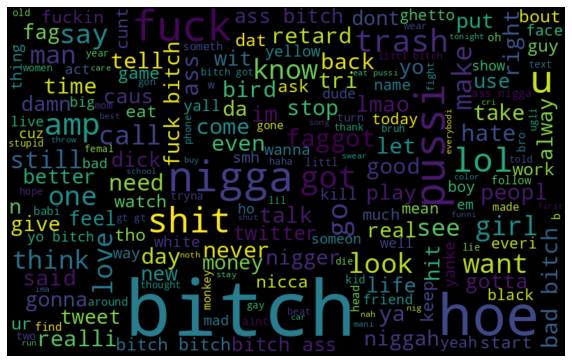

In [13]:
# visualizing which of the word is most commonly used in the twitter dataset
from wordcloud import WordCloud
all_words = ' '.join([text for text in dataset['processed_tweets'] ])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

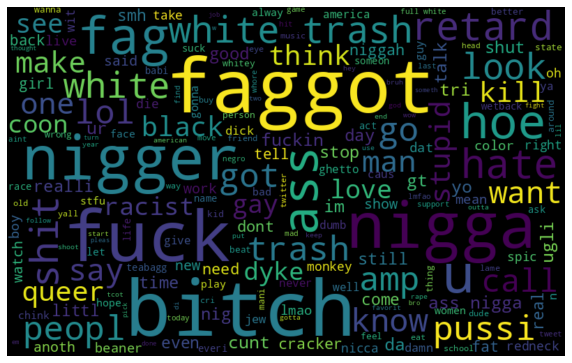

In [14]:
# visualizing which of the word is most commonly used for hatred speech
hatred_words = ' '.join([text for text in dataset['processed_tweets'][dataset['class'] == 0]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(hatred_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

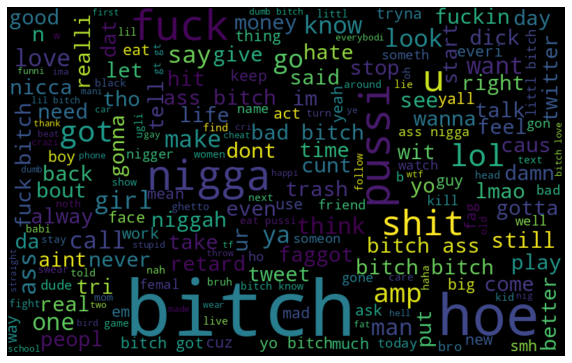

In [15]:

# visualizing which of the word is most commonly used for offensive speech
offensive_words = ' '.join([text for text in dataset['processed_tweets'][dataset['class'] == 1]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(offensive_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Word2vec embeddings

In [16]:
#Word2vec embeddings
def get_vec(x):
  doc = nlp(x)
  return doc.vector

In [17]:
dataset['vec'] = dataset['processed_tweets'].apply(lambda x: get_vec(x))

In [18]:
dataset.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,processed_tweets,vec
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,woman complain clean hous amp man alway take t...,"[-0.1626911, 0.2962211, -2.473039, -0.42398775..."
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dat cold tyga dwn bad cuffin dat hoe st place,"[-0.67341727, 1.0804446, -0.17582273, -0.45896..."
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,dawg ever fuck bitch start cri confus shit,"[-0.062238753, 1.0075729, -1.4195487, 1.052822..."
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,look like tranni,"[0.023233334, 0.8588333, -1.0036668, -0.75697,..."
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,shit hear might true might faker bitch told ya,"[1.1837283, 1.5942438, -2.0920577, -1.1199623,..."


In [20]:
X = dataset['vec'].to_numpy()
X = X.reshape(-1,1)

In [21]:
X = np.concatenate(np.concatenate(X,axis = 0),axis = 0).reshape(-1,300)

In [22]:
y = dataset['class'].astype(int)

Logistic Regression

In [23]:

X_train_word, X_test_word, y_train, y_test = train_test_split(X, y, random_state=50, test_size=0.2)
model = LogisticRegression(penalty='l2',C=1,solver='liblinear',max_iter=100,multi_class='auto',class_weight='balanced')
model.fit(X_train_word,y_train)
y_preds = model.predict(X_test_word)
report = classification_report( y_test, y_preds )
print(report)
acc=accuracy_score(y_test,y_preds)
print("Logistic Regression, Accuracy Score:" , acc)

precision,recall,fscore,support=score(y_test,y_preds,average='weighted')
LR_F1=fscore
print('Logistic regression F1:{}'.format(LR_F1))

              precision    recall  f1-score   support

           0       0.31      0.43      0.36       288
           1       0.93      0.85      0.89      3847
           2       0.65      0.82      0.72       822

    accuracy                           0.82      4957
   macro avg       0.63      0.70      0.66      4957
weighted avg       0.85      0.82      0.83      4957

Logistic Regression, Accuracy Score: 0.8236836796449465
Logistic regression F1:0.8332488088424888


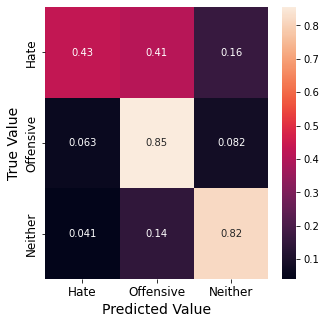

In [24]:
#Confusion Matrix for Logistic regression with word2vec
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = panda.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True)
plt.ylabel(r'True Value',fontsize=14)
plt.xlabel(r'Predicted Value',fontsize=14)
plt.tick_params(labelsize=12)

naive bayes

In [25]:

X_train_word, X_test_word, y_train, y_test = train_test_split(X, y, random_state=10, test_size=0.2)
nb=GaussianNB()
nb.fit(X_train_word,y_train)
y_preds = nb.predict(X_test_word)
acc2=accuracy_score(y_test,y_preds)

report = classification_report( y_test, y_preds )
print(report)
print("Naive Bayes, Accuracy Score:",acc2)

precision,recall,fscore,support=score(y_test,y_preds,average='weighted')
NB_F1=fscore
print('Naive Bayes F1:{}'.format(NB_F1))

              precision    recall  f1-score   support

           0       0.16      0.44      0.23       285
           1       0.94      0.64      0.76      3815
           2       0.46      0.84      0.60       857

    accuracy                           0.66      4957
   macro avg       0.52      0.64      0.53      4957
weighted avg       0.81      0.66      0.70      4957

Naive Bayes, Accuracy Score: 0.6635061529150696
Naive Bayes F1:0.7022157803710112


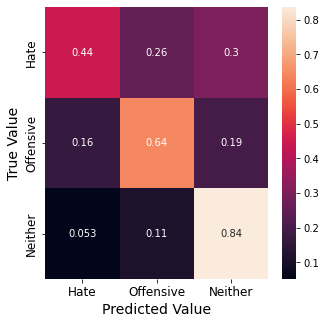

In [26]:
#Confusion Matrix for NB with word2vec
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = panda.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True)
plt.ylabel(r'True Value',fontsize=14)
plt.xlabel(r'Predicted Value',fontsize=14)
plt.tick_params(labelsize=12)

Support vector machine

In [27]:

support =LinearSVC(loss='hinge',max_iter=100,penalty='l2',random_state=50)
support.fit(X_train_word,y_train)
y_preds = support.predict(X_test_word)
acc3=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("SVM, Accuracy Score:" , acc3)

precision,recall,fscore,support=score(y_test,y_preds,average='weighted')
SVM_F1=fscore
print('SVM F1:{}'.format(SVM_F1))

              precision    recall  f1-score   support

           0       0.17      0.18      0.17       285
           1       0.92      0.81      0.86      3815
           2       0.54      0.81      0.65       857

    accuracy                           0.77      4957
   macro avg       0.54      0.60      0.56      4957
weighted avg       0.81      0.77      0.78      4957

SVM, Accuracy Score: 0.7744603590881581
SVM F1:0.7847591662357035


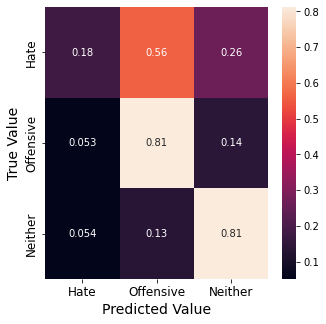

In [28]:
#Confusion Matrix for SVM with word2vec
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = panda.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True)
plt.ylabel(r'True Value',fontsize=14)
plt.xlabel(r'Predicted Value',fontsize=14)
plt.tick_params(labelsize=12)

Comparison of accuracies for all three model

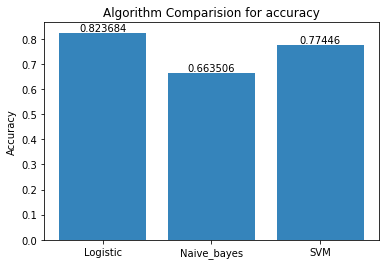

In [29]:

objects = ('Logistic', 'Naive_bayes', 'SVM')
y_pos = np.arange(len(objects))
performance = [acc,acc2,acc3]
bars=plt.bar(y_pos, performance, align='center', alpha=0.9)
plt.bar_label(bars)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Algorithm Comparision for accuracy')
plt.show()


Comparison of accuracies for all three model

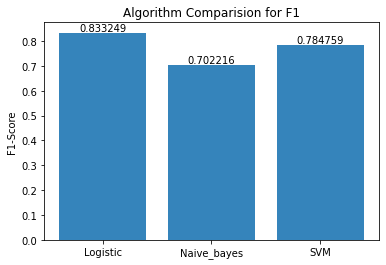

In [30]:

objects = ('Logistic', 'Naive_bayes', 'SVM')
y_pos = np.arange(len(objects))
performance = [LR_F1,NB_F1,SVM_F1]
bars=plt.bar(y_pos, performance, align='center', alpha=0.9)
plt.bar_label(bars)
plt.xticks(y_pos, objects)
plt.ylabel('F1-Score')
plt.title('Algorithm Comparision for F1')
plt.show()